In [1]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-dyyn_5c4
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-dyyn_5c4
     |████████████████████████████████| 50 kB 1.6 MB/s eta 0:00:011
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=18326 sha256=db99efc581706910405e9be60740286952f954e210e8f70b439b7dd988fd6d20
  Stored in directory: /tmp/pip-ephem-wheel-cache-ipp9rcdi/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [2]:
#-------Import Dependencies-------#
%matplotlib inline
import tensorflow as tf
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import cv2
from keras.preprocessing import image
import matplotlib.pyplot as plt
import io
import requests


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc,plot_confusion_matrix

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom

from keras import backend as K
from keras import layers,Input
from keras.preprocessing.image import save_img
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential,Model,Input
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,InputLayer,Reshape
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D,Layer
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
import efficientnet.keras as efn 
from distutils.dir_util import copy_tree
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

Using TensorFlow backend.


In [3]:
# detect and init the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

# instantiate a distribution strategy
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [4]:
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path('shopee-round-2-product-detection-challenge')
shopeedatasetdir = GCS_PATH+'/train/train/'
shopeetestdir = GCS_PATH+'/test/test/'
shopeedir = 'gs://asoygeboy/kaggle/input/shopee/shopee/'
GCS_PATH = KaggleDatasets().get_gcs_path('facemask-dataset')
facemaskdir = GCS_PATH+'/Mask/Mask/'
GCS_PATH = KaggleDatasets().get_gcs_path('apparel-images-dataset')
appareldir = GCS_PATH+'/black_pants/'

In [5]:
shopeedataset = tf.io.gfile.glob(shopeedatasetdir+'*/*.jpg')
shopeetest = tf.io.gfile.glob(shopeetestdir+'*/*.jpg')
apparel = tf.io.gfile.glob(appareldir+'*.jpg')
facemask = tf.io.gfile.glob(facemaskdir+'*.jpg')
privat = tf.io.gfile.glob(shopeedir+'*/*/*.jpg')

In [6]:
TrainImagePaths = shopeedataset+apparel+facemask+privat

In [7]:
labell = []
for filenames in shopeedataset:
    if (filenames[-3:] == 'jpg'):
        labell.append(filenames[-39:-37])
for filenames in apparel:
    if (filenames[-3:] == 'jpg'):
        labell.append('29')
for filenames in facemask:
    if (filenames[-3:] == 'jpg'):
        labell.append('32')
for filenames in privat:
    if (filenames[-3:] == 'jpg'):
        labell.append(filenames[42:44])

In [8]:
train = pd.DataFrame(list(zip(TrainImagePaths, labell)),columns=['filename', 'category'])

In [9]:
train

,filename,category
0,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00
1,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00
2,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00
3,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00
4,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00
...,...,...
111716,gs://asoygeboy/kaggle/input/shopee/shopee/37/3...,37
111717,gs://asoygeboy/kaggle/input/shopee/shopee/37/3...,37
111718,gs://asoygeboy/kaggle/input/shopee/shopee/37/3...,37
111719,gs://asoygeboy/kaggle/input/shopee/shopee/37/3...,37


In [10]:
test_dir = 'gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8fa604ec191f3f1b40ac6/test/'
test = pd.read_csv('gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8fa604ec191f3f1b40ac6/test.csv')

In [11]:
train['category'] = train['category'].astype('object')
category_replace = {0:'00',1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'}
train['category'] = train['category'].replace(category_replace.keys(), category_replace.values()).astype('str')

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111721 entries, 0 to 111720
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  111721 non-null  object
 1   category  111721 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [13]:
train.head()

,filename,category
0,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00
1,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00
2,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00
3,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00
4,gs://kds-d70f1a2558903a77433dab41e4a2f05bdbd8f...,00


count     111721
unique        42
top           29
freq        3009
Name: category, dtype: object

median counts: 2678.50
mean counts: 2660.02


,32,37,23,18,28,21,34,11,22,15,...,08,27,01,03,04,30,24,17,33,29
category,2312,2347,2540,2556,2561,2598,2599,2620,2623,2632,...,2700,2702,2702,2703,2703,2705,2705,2753,2824,3009


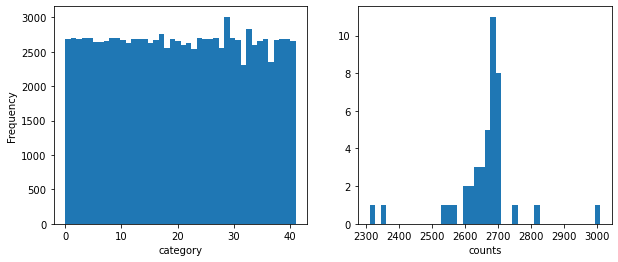

In [14]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

train['category'].astype('int').plot.hist(bins=42, ax=ax1);
plt.xlabel('category');
print(train['category'].describe())
print('\nmedian counts: {:.2f}'.format(train['category'].value_counts().median()))
print('mean counts: {:.2f}'.format(train['category'].value_counts().mean()))
ax2.hist(train['category'].value_counts(), bins=42)
ax1.set_xlabel('category'), ax2.set_xlabel('counts')

pd.DataFrame(train['category'].value_counts().sort_values()).T

In [15]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [16]:
dftrain, dfval = train_test_split(train,stratify=train['category'], test_size=0.2)

In [17]:
# convert to numpy array
train_paths = np.array(dftrain['filename'])
# convert to one-hot-encoding-labels
train_labels = to_categorical(dftrain['category'])

# convert to numpy array
valid_paths = np.array(dfval['filename'])

# convert to one-hot-encoding-labels
valid_labels = to_categorical(dfval['category'])

test_paths = np.array(shopeetest)

count     89376
unique       42
top          29
freq       2407
Name: category, dtype: object

median counts: 2142.50
mean counts: 2128.00


,32,37,23,18,28,21,34,11,22,15,...,08,27,04,03,01,30,24,17,33,29
category,1850,1878,2032,2045,2049,2078,2079,2096,2098,2106,...,2160,2161,2162,2162,2162,2164,2164,2202,2259,2407


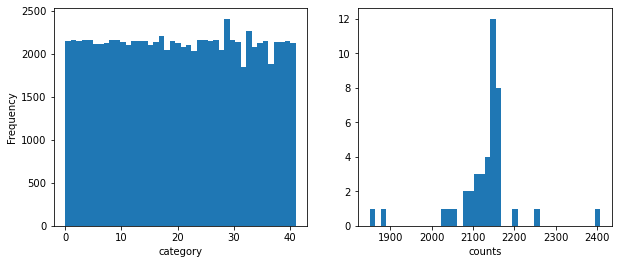

In [18]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

dftrain['category'].astype('int').plot.hist(bins=42, ax=ax1);
plt.xlabel('category');
print(dftrain['category'].describe())
print('\nmedian counts: {:.2f}'.format(dftrain['category'].value_counts().median()))
print('mean counts: {:.2f}'.format(dftrain['category'].value_counts().mean()))
ax2.hist(dftrain['category'].value_counts(), bins=42)
ax1.set_xlabel('category'), ax2.set_xlabel('counts')

pd.DataFrame(dftrain['category'].value_counts().sort_values()).T

count     22345
unique       42
top          29
freq        602
Name: category, dtype: object

median counts: 536.00
mean counts: 532.02


,32,37,23,18,28,21,34,11,22,15,...,08,01,24,27,30,03,04,17,33,29
category,462,469,508,511,512,520,520,524,525,526,...,540,540,541,541,541,541,541,551,565,602


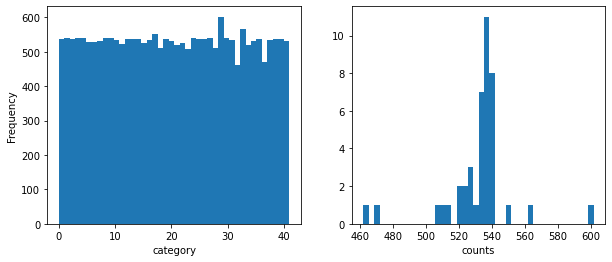

In [19]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,4))

dfval['category'].astype('int').plot.hist(bins=42, ax=ax1);
plt.xlabel('category');
print(dfval['category'].describe())
print('\nmedian counts: {:.2f}'.format(dfval['category'].value_counts().median()))
print('mean counts: {:.2f}'.format(dfval['category'].value_counts().mean()))
ax2.hist(dfval['category'].value_counts(), bins=42)
ax1.set_xlabel('category'), ax2.set_xlabel('counts')

pd.DataFrame(dfval['category'].value_counts().sort_values()).T

In [20]:
img_size=456
BATCH_SIZE= 16 * strategy.num_replicas_in_sync
EPOCHS = 32
AUTO = tf.data.experimental.AUTOTUNE

In [21]:
def decode_image(filename, label=None, image_size=(img_size, img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label
    
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_saturation(image, lower=0, upper=2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_flip_up_down(image)
    
    
    if label is None:
        return image
    else:
        return image, label
    
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [22]:
with strategy.scope():
    """
    This essentailly takes our model and makes it 
    compatible to train on a TPU.
    """
    model_base = efn.EfficientNetB5(weights='noisy-student',include_top=False,input_shape=[img_size,img_size,3])

    # only if we want to freeze layers
    for layer in model_base.layers:
        layer.trainable = False
    set_trainable = False
    for layer in model_base.layers:
        if layer.name == 'block5a_expand_conv':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    model = tf.keras.Sequential(
      [
        Reshape(input_shape=(img_size*img_size,), target_shape=(img_size, img_size, 3), name="image"),
        model_base,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(42, activation='softmax')
      ])
    
    """
    Compiling the model using the RMSProp optimizer 
    and Sparse Categorical Crossentropy loss
    """
    

    model.summary()

115261440/115255328 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (Reshape)              (None, 456, 456, 3)       0         
_________________________________________________________________
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 42)                86058     
Total params: 28,599,578
Trainable params: 26,335,274
Non-trainable params: 2,264,304
_________________________________________________________________


In [30]:
with strategy.scope():    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=.0002),
        metrics=['acc']
        )

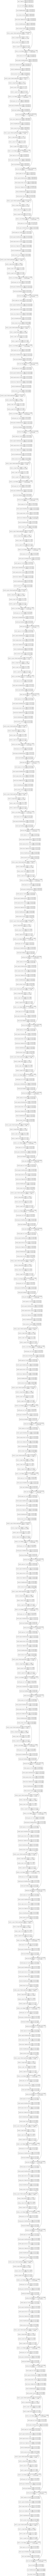

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model_base, to_file='model_base.png', show_shapes=True)
from IPython.display import Image
Image(filename='model_base.png') 

In [24]:
for layer in model_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2ec2d2a610> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2ec2d1fbd0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2ec2d3d450> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f2ec2ced610> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f2ec2cb1050> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2ec2ddf450> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f2ec2c3a710> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2ec2c0da10> False
<tensorflow.python.keras.layers.core.Reshape object at 0x7f2ec2c33690> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2ec2d76b10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2ec2d314d0> False
<tensorflow.python.keras.layers.

In [25]:
model_base.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 456, 456, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

block4b_expand_conv (Conv2D)    (None, 29, 29, 768)  98304       block4a_project_bn[0][0]         
__________________________________________________________________________________________________
block4b_expand_bn (BatchNormali (None, 29, 29, 768)  3072        block4b_expand_conv[0][0]        
__________________________________________________________________________________________________
block4b_expand_activation (Acti (None, 29, 29, 768)  0           block4b_expand_bn[0][0]          
__________________________________________________________________________________________________
block4b_dwconv (DepthwiseConv2D (None, 29, 29, 768)  6912        block4b_expand_activation[0][0]  
__________________________________________________________________________________________________
block4b_bn (BatchNormalization) (None, 29, 29, 768)  3072        block4b_dwconv[0][0]             
__________________________________________________________________________________________________
block4b_ac

block6d_expand_bn (BatchNormali (None, 15, 15, 1824) 7296        block6d_expand_conv[0][0]        
__________________________________________________________________________________________________
block6d_expand_activation (Acti (None, 15, 15, 1824) 0           block6d_expand_bn[0][0]          
__________________________________________________________________________________________________
block6d_dwconv (DepthwiseConv2D (None, 15, 15, 1824) 45600       block6d_expand_activation[0][0]  
__________________________________________________________________________________________________
block6d_bn (BatchNormalization) (None, 15, 15, 1824) 7296        block6d_dwconv[0][0]             
__________________________________________________________________________________________________
block6d_activation (Activation) (None, 15, 15, 1824) 0           block6d_bn[0][0]                 
__________________________________________________________________________________________________
block6d_se

In [26]:
#-------Callbacks-------------#
best_model_weights = './basemodeltpu.h5'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs/train',
    histogram_freq=0,
    batch_size=BATCH_SIZE,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=20,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

checkpoint_path = "./weights.{epoch:02d}-{val_loss:.2f}.h5"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, verbose=1, save_weights_only=True,
        period=5)

es = EarlyStopping(monitor='val_loss', mode='min', patience=6, 
                   restore_best_weights=True, verbose=1)


callbacks = [cp_callback]

/opt/conda/lib/python3.7/site-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '
/opt/conda/lib/python3.7/site-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


In [ ]:
history = model.fit(
    train_dataset, 
    steps_per_epoch  = len(dftrain['filename']) // BATCH_SIZE+1, 
    validation_data  = valid_dataset,
    validation_steps = len(dfval['filename']) // BATCH_SIZE+1,
    epochs = EPOCHS, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/32
699/699 [==============================] - ETA: 0s - loss: 0.0986 - acc: 0.9675
Epoch 00001: saving model to ./weights.01-1.50.h5
699/699 [==============================] - 200s 286ms/step - loss: 0.0986 - acc: 0.9675 - val_loss: 1.4959 - val_acc: 0.7727
Epoch 2/32
699/699 [==============================] - 170s 243ms/step - loss: 0.0570 - acc: 0.9817 - val_loss: 1.5581 - val_acc: 0.7766
Epoch 3/32
699/699 [==============================] - 169s 242ms/step - loss: 0.0410 - acc: 0.9868 - val_loss: 1.6363 - val_acc: 0.7752
Epoch 4/32
699/699 [==============================] - 170s 243ms/step - loss: 0.0348 - acc: 0.9887 - val_loss: 1.6587 - val_acc: 0.7772
Epoch 5/32
699/699 [==============================] - 169s 242ms/step - loss: 0.0296 - acc: 0.9906 - val_loss: 1.6946 - val_acc: 0.7766
Epoch 6/32
699/699 [==============================] - ETA: 0s - loss: 0.0269 - acc: 0.9916
Epoch 00006: saving model to ./weights.06-1.70.h5
699/699 [==============================] - 173s 2

In [ ]:
show_final_history(history)

In [ ]:
model.save("modeltpu.h5")
print("Weights Saved")

In [ ]:
model.load_weights(best_model_weights)
model_score = model.evaluate_generator(val_gen,steps=val_gen.samples // batch_size+1, verbose = 1,\)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("modeltpu.json","w") as json_file:
    json_file.write(model_json)
    
model.save("modeltpu.h5")
print("Weights Saved")

In [ ]:
%%time
#Confusion Matrix and Classification Report
val_gen.reset()
Y_pred = model.evaluate_generator(val_gen, 
                                 steps=val_gen.samples // batch_size+1, 
                                 verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(val_gen.classes, y_pred))

In [ ]:
print('Classification Report')
print(classification_report(val_gen.classes, y_pred))

In [ ]:
# load model
model = load_model('/kaggle/input/shopee/base.hdf')
# summarize model.
model.summary()

In [ ]:
test_dataset_tta = (
        tf.data.Dataset
        .from_tensor_slices(test_paths)
        .map(decode_image, num_parallel_calls=AUTO)
        .cache()
        .map(data_augment, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
)

tta_times = 5
probabilities = []

for i in range(tta_times+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(test_dataset_tta, verbose=1))
    
tta_pred = np.mean(probabilities, axis=0)

In [ ]:
# change with prediction
test['category'] = tta_pred.argmax(axis=1)

# then add zero-padding
test['category'] = test['category'].apply(lambda x: str(x).zfill(2))

In [ ]:
test_df.to_csv('sub_with_tta.csv', index=False)

In [ ]:
test_df